### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 4

#### Дисциплина: Интеллектуальный анализ данных

##### Студент: Матюхин Григорий Васильевич
##### Группа: НПИбд-01-21

## Москва 2024
***

### Вариант №17 

- Japanese Credit Screening Data Set 
- Название файла: crx.data 
- Ссылка: https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/ 
- Первый признак: A2 (столбец No 2) 
- Второй признак: A8 (столбец No 8) 
- Третий признак: A15 (столбец No 15) 
- Класс: A16 (столбец No 16) 
- Метод обработки пропущенных значений – медиана признака  
- Метод нормализации признаков – масштабирование на интервал [-1, 1]  
- Алгоритм снижения размерности данных – удаление признака с самой низкой дисперсией  
- Метод валидации модели – повторяющиеся случайные разбиения на обучающую и тестовую выборки по 5 блокам  
- Показатель качества модели – F-мера (f1)  

## 1. Загружаем датасет

Ссылка, указанная в задании не работает. Используем другую: https://archive.ics.uci.edu/dataset/28/japanese+credit+screening

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
japanese_credit_screening = fetch_ucirepo(id=28) 

In [2]:
japanese_credit_screening["data"].keys()

dict_keys(['ids', 'features', 'targets', 'original', 'headers'])

In [3]:
japanese_credit_screening["data"]["features"].keys()

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14', 'A15'],
      dtype='object')

In [4]:
import pandas as pd

In [5]:
CLS = "A16"
FEAT1 = "A2"
FEAT2 = "A8"
FEAT3 = "A15"
FEATS = [FEAT1, FEAT2, FEAT3]

In [6]:
df = pd.DataFrame(japanese_credit_screening["data"]["targets"])
for f in FEATS:
    df[f] = japanese_credit_screening["data"]["features"][f]
df.head()

,A16,A2,A8,A15
0,+,30.83,1.25,0
1,+,58.67,3.04,560
2,+,24.50,1.50,824
3,+,27.83,3.75,3
4,+,20.17,1.71,0


## 2. Подготовка датасета

### 2.1. Удаление пропущенных значений

In [7]:
import numpy as np

In [8]:
df = df.replace("?", np.nan)
for f in FEATS:
    df[f] = df[f].apply(pd.to_numeric)

In [9]:
df[CLS].notna().all()

np.True_

In [10]:
for f in FEATS:
    if bool(df[f].notna().all()):
        print(f"Feature {f} is fine.")
    else:
        print(f"Feature {f} has NaNs. Chanigng to median.")
        df[f] = df[f].fillna(df[f].median())
        print(f"Does feature {f} have NaNs now? {not bool(df[f].notna().all())}")

Feature A2 has NaNs. Chanigng to median.
Does feature A2 have NaNs now? False
Feature A8 is fine.
Feature A15 is fine.


### 2.2. Объединение классов

In [11]:
df[CLS].unique()

array(['+', '-'], dtype=object)

У нас всего два класса. Объединение не требуется. Но заменим строки на числа.

In [12]:
df[CLS] = df[CLS].apply(lambda x: 1 if x == "+" else 0)
df[CLS].unique()

array([1, 0])

## 3. Нормализация признаков

In [13]:
from sklearn.preprocessing import MaxAbsScaler
abs_scaler = MaxAbsScaler()
df[FEATS] = abs_scaler.fit_transform(df[FEATS])
df.head()

,A16,A2,A8,A15
0,1,0.384174,0.043860,0.00000
1,1,0.731090,0.106667,0.00560
2,1,0.305296,0.052632,0.00824
3,1,0.346791,0.131579,0.00003
4,1,0.251340,0.060000,0.00000


## 4. Визуализация набора данных

In [14]:
import matplotlib.pyplot as plt

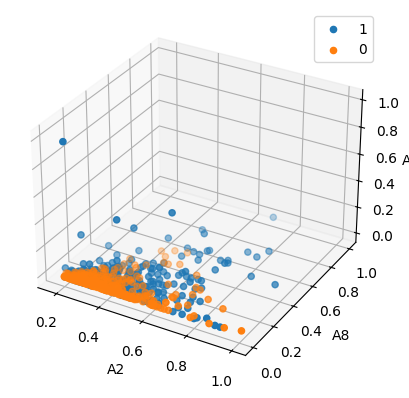

In [15]:
CLASSES = df[CLS].unique()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for i in CLASSES:
    df_k = df[df[CLS] == i]
    ax.scatter(df_k[FEAT1], df_k[FEAT2], df_k[FEAT3], marker="o", label=i)

ax.set_xlabel(FEAT1)
ax.set_ylabel(FEAT2)
ax.set_zlabel(FEAT3)
plt.legend()
plt.show()

## 5. Уменьшение размерности

In [16]:
variances = dict()
for f in FEATS:
    variances[f] = np.var(df[f])

print(variances)

min_var = min(variances, key=variances.get)

FEATS2 = list(FEATS)
FEATS2.remove(min_var)
df2 = df.drop([min_var], axis=1)
df2.head()

{'A2': np.float64(0.021810586895572227), 'A8': np.float64(0.013767831344095729), 'A15': np.float64(0.002710582826007981)}


,A16,A2,A8
0,1,0.384174,0.043860
1,1,0.731090,0.106667
2,1,0.305296,0.052632
3,1,0.346791,0.131579
4,1,0.251340,0.060000


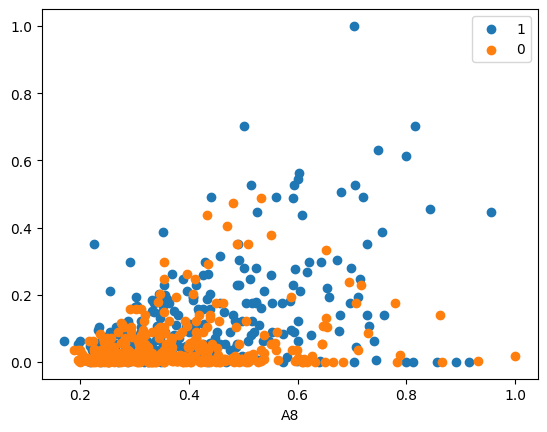

In [17]:
ax = plt.axes()

for i in CLASSES:
    df_k = df2[df[CLS] == i]
    ax.scatter(df_k[FEAT1], df_k[FEAT2], marker="o", label=i)

ax.set_xlabel(FEAT1)
ax.set_xlabel(FEAT2)
plt.legend()
plt.show()

## 6. Разделения датасета и классификация тестовой выборки

In [18]:
# k nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


X = df2[FEATS2]
y = df2[CLS]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=31337)

best_k = 0
best_score = 0

for i in range(2, 10):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(X_train, y_train)

    score = knn_model.score(X_test, y_test)
    print(i, score)
    if score > best_score:
        best_score = score
        best_k = i

print(f"best k = {best_k}, score = {best_score}")

2 0.6069364161849711
3 0.6184971098265896
4 0.6416184971098265
5 0.6416184971098265
6 0.6763005780346821
7 0.6705202312138728
8 0.6705202312138728
9 0.6647398843930635
best k = 6, score = 0.6763005780346821


## 7. Отчет о классификации

In [19]:
from sklearn.metrics import classification_report

y_pred = knn_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70        96
           1       0.63      0.61      0.62        77

    accuracy                           0.66       173
   macro avg       0.66      0.66      0.66       173
weighted avg       0.66      0.66      0.66       173



In [20]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_test, y_pred)).style.background_gradient(cmap='Blues')

,0,1
0,68,28
1,30,47


## 8. Создание модели классификации в 3D

0.6473988439306358


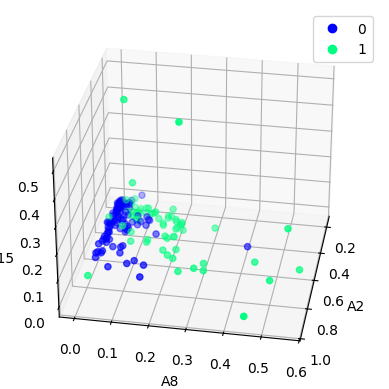

In [21]:
knn_model = KNeighborsClassifier(n_neighbors=best_k)

X,y = df[FEATS], df[CLS]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
knn_model.fit(X_train, y_train)

score = knn_model.score(X_test, y_test)
knn_predictions = knn_model.predict(X_test)
print(score)

ax = plt.axes(projection='3d')

scatter = ax.scatter(X_test[FEAT1], X_test[FEAT2], X_test[FEAT3], c=knn_predictions, cmap="winter")

ax.set_xlabel(FEAT1)
ax.set_ylabel(FEAT2)
ax.set_zlabel(FEAT3)

plt.legend(*scatter.legend_elements())

ax.view_init(30, 10)

plt.show()

0.6589595375722543


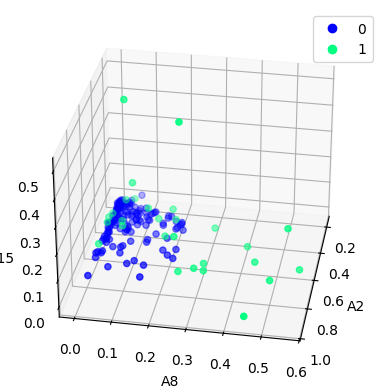

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X = df[FEATS]
y = df[CLS]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

score = gnb_model.score(X_test, y_test)
gnb_predictions = gnb_model.predict(X_test)
print(score)

ax = plt.axes(projection='3d')

scatter = ax.scatter(X_test[FEAT1], X_test[FEAT2], X_test[FEAT3], c=gnb_predictions, cmap="winter")

ax.set_xlabel(FEAT1)
ax.set_ylabel(FEAT2)
ax.set_zlabel(FEAT3)

plt.legend(*scatter.legend_elements())

ax.view_init(30, 10)

plt.show()

## 9. Оценка качества классификаторов

In [23]:
# Repeated Random Test-Train Splits
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score

kfold_split = ShuffleSplit(n_splits=5, test_size=0.30)

knn_score = f1_score(y, knn_model.predict(X))
gnb_score = f1_score(y, gnb_model.predict(X))

print("Knn: ", knn_score)
print("Gnb: ", gnb_score)

Knn:  0.6462715105162524
Gnb:  0.4470588235294118


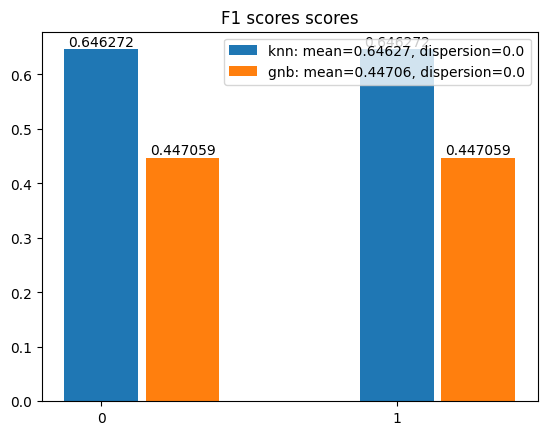

In [24]:
import numpy as np

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
width = 0.25
multiplier = 0
ax = plt.axes()
for klass, name in [(knn_score, 'knn'), (gnb_score, 'gnb')]:
    mean = round(float(np.mean(klass)), 5)
    dispersion = round(float(np.std(klass)), 5)
    offset = (width * multiplier)
    ax.bar(CLASSES + offset, klass, width=width, label=f"{name}: {mean=}, {dispersion=}")
    ax.set_xticks(CLASSES, labels=CLASSES)
    ax.bar_label(ax.containers[-1])
    multiplier += 1.1


plt.legend()
plt.title("F1 scores scores")
plt.show()

## 10. Визуализация лучшего классификатора

In [25]:
klasses = [(knn_score, 'knn'), (gnb_score, 'gnb')]
best_klass = max(klasses, key=lambda x: np.mean(x[0]))
print(best_klass[1])

knn


In [26]:
best_model = eval(best_klass[1] + "_model")

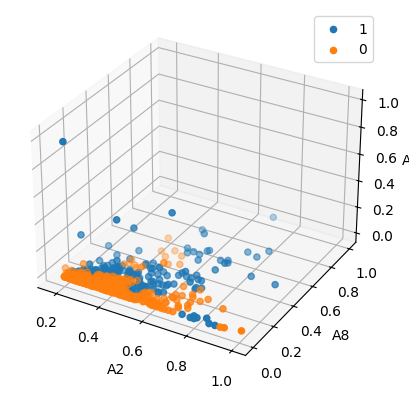

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = df[FEATS]
y = best_model.predict(X)


for i in CLASSES:
    df_k = df[y == i]
    ax.scatter(df_k[FEAT1], df_k[FEAT2], df_k[FEAT3], marker='o', label=i)

ax.set_xlabel(FEAT1)
ax.set_ylabel(FEAT2)
ax.set_zlabel(FEAT3)

plt.legend()

plt.show()